In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings("ignore")


In [29]:
def transform_x(x_df, enc):
    """
    Build min max scaler/one hot encoder from scikit learn
    """
    x_enc = enc.transform(x_df)
    feature_names = enc.get_feature_names_out(x_df.columns)
    x_enc_df = pd.DataFrame(x_enc, columns=feature_names)
    return x_enc_df

def preprocess_x(x_df, enc, scaler):
    """
    one hot encode categorical variable using enc given
    scale numeric variable using scaler given
    combine the 2 datasets
    """
    cat_x_df = transform_x(x_df[CAT_VAR], enc)

    num_x_df = transform_x(x_df[NUMERIC_VAR], scaler)
    final_x_df = pd.concat([cat_x_df, num_x_df], axis = 1).reset_index(drop=True)
    return final_x_df

def scoring(y_true, y_pred):
    """
    Calculate metrics given predicted labels and ground truth labels
    """
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    results = {'recall': recall, 'precision':precision, 'auc': roc_auc}

    return results

# currently not using
def get_threshold_for_fixed_fpr(y_test, y_pred, fixed_fpr=0.9):
    """
    get threshold given a fixed fpr (currently not using)
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)
    display(pd.DataFrame([fpr, tpr, thresholds], columns=['fpr', 'tpr', 'thresholds']))
    idx = np.argmax(fpr > fixed_fpr)
    return thresholds[idx]

def grid_search_cv(params, k, datax, datay, weights=None):
    """
    Implement grid search with kfold cross validation for logistic regression 
    precision, recall, auc calculated
    """
    results = []
    for c in params:
        cresult= {'recall': 0, 'precision':0, 'auc':0, 'C':c}
        kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
        for i, (train_index, test_index) in enumerate(kf.split(datax)):
            # split dataset
            t_X, v_X = datax.iloc[train_index,:], datax.iloc[test_index,:]
            t_y, v_y = datay.iloc[train_index], datay.iloc[test_index]
            # Train
            lg = LogisticRegression(random_state=SEED, class_weight=weights, n_jobs=3, C=c, max_iter=10000)
            lg.fit(t_X, t_y)
            # Test
            val_probs = lg.predict_proba(v_X)
            v_y_pred = val_probs[:,1] > THRESHOLD
            # metrics calculation
            result = scoring(v_y , v_y_pred)
            cresult['precision'] += result['precision'] / k
            cresult['recall'] += result['recall'] / k
            cresult['auc'] += result['auc'] / k
        results.append(cresult)
    results_df = pd.DataFrame(results).sort_values(by='recall', ascending=False)
    return results_df

def stratified_grid_search_cv(params, k, datax, datay, weights='balanced'):
    """
    Implement grid search with stratified kfold cross validation for logistic regression with balanced class weights
    precision, recall, auc calculated
    """
    results = []
    for c in params:
        cresult= {'recall': 0, 'precision':0, 'auc':0, 'C':c}
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
        for i, (train_index, test_index) in enumerate(kf.split(datax, datay)):
            # split dataset
            t_X, v_X = datax.iloc[train_index,:], datax.iloc[test_index,:]
            t_y, v_y = datay.iloc[train_index], datay.iloc[test_index]
            # Train
            lg = LogisticRegression(random_state=SEED, class_weight=weights, n_jobs=3, C=c, max_iter=10000)
            lg.fit(t_X, t_y)
            # Test
            val_probs = lg.predict_proba(v_X)
            v_y_pred = val_probs[:,1]  > THRESHOLD
            # metrics
            result = scoring(v_y , v_y_pred)
            cresult['precision'] += result['precision'] / k
            cresult['recall'] += result['recall'] / k
            cresult['auc'] += result['auc'] / k
        results.append(cresult)
    results_df = pd.DataFrame(results).sort_values(by='recall', ascending=False)
    return results_df

def plot_confusion_matrix(y_true, y_pred, class_names=['Normal', 'Fraid']):

    cnf_matrix = confusion_matrix(y_true, y_pred)

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Reds" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    return 

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return


In [30]:
## VARIABLES ##
DATA_CSV = './bankfraud/Base.csv'
TARGET = 'fraud_bool'
CAT_VAR = ['payment_type', 'employment_status', 'has_other_cards', 'housing_status',
           'foreign_request', 'source','email_is_free', 'phone_home_valid', 'phone_mobile_valid',
           'device_os', 'keep_alive_session']
CAT_VAR = ['employment_status', 'housing_status']
NUMERIC_VAR = ['income', 'name_email_similarity', 'prev_address_months_count',
               'current_address_months_count', 'customer_age', 'days_since_request', 
               'intended_balcon_amount','zip_count_4w', 'velocity_6h', 'velocity_24h',
                'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
                'credit_risk_score',  'bank_months_count', 'proposed_credit_limit',
                'session_length_in_minutes','device_distinct_emails_8w', 
                'device_fraud_count', 'month']
NUMERIC_VAR = ['income', 'customer_age','credit_risk_score', 'bank_months_count']
GREEN = '#008000'
RED = '#FF0000'
SEED = 0
PARAMS = [0.01, 0.1, 1, 10, 100]
THRESHOLD = 0.75

## Model Comparison ##
Dataset has 1% positive/fraud cases, very imbalanced
1. level 1: feature engineering, metric
2. level 1.5: feature engineering, metric, sampling
3. level 2: feature engineering, metric, stratified training, weights
4. level 2.5: feature engineering, metric, stratified training, weights, sampling

## Raw features ##
1. **<u>income</u>**, 
2.  **<u>customer_age</u>**
3. intended_balcon_amount: initial transferred amount for application
4. payment_type: credit payment plan type
5. **<u>employment_status</u>**, 
6.  **<u>credit_risk_score</u>**, 
7.  **<u>housing_status</u>**, 
8. proposed_credit_limit
10. month

## Derived features ##
1. name_email_similarity: metric of similarity between email & name
2. prev_address_months_count: no. of mths in prev registered address
3. current_address_months_count: no. of mths in current registered address
4. days_since_request
5. email_is_free
6. phone_home_valid, 
7. phone_mobile_valid,
8. bank_months_count: no. of mths prev account is held
9. has_other_cards: has other cards with the bank?
10. foreign_request: origin country different from bank's country
11. source: source of application (browser/app)
12. session_length_in_minutes: len of user session
13. device_os, 
14. keep_alive_session: user option on logout

## Aggregated features
1. zip_count_4w: No. of applicants within the same zip code
2. velocity_6h: Average no. of applicants made per hour in the past 6 hours
3. velocity_24h: Average no. of applicants made per hour in the past 24 hours
4. velocity_4w: Average no. of applicants made per hour in the past 4 weeks
5. bank_branch_count_8w: No. of applicants in selected bank branch in last 8 weeks
6. date_of_birth_distinct_emails_4w: No. of emails for applicants with same bday in last 4 weeks
7. device_distinct_emails_8w: No. of distinct emails in banking website from used device in the last 8 weeks
8. device_fraud_count: No. of fraudulent applications with used device

## Metrics ##
Accuracy is not the right metric, even if model predicted 100% no fraud, will still get 99% accuracy
1. Recall : % of real fraud cases detected
2. Precision : % of predicted fraud cases are correct
3. AUC: Area under ROC Curve, measure ability of a classifier to differentiate between 2 classes

## Stratifed training ##
* When doing hyperparameter tuning, ensure that the train and validation set has the same proportion
* As positive cases are very low, w/o straitied sampling, likely that train set has no positive cases

## Weights ##
* Balanced weights gives a heigher weights > 1 to the miniorty class while giving the majority class a smaller weight <1, the ratio of the weighs is proportional to the frequency of the class
* The model will penalise more when the minority class is predicted wrongly and penalise less when the majority calss is predicted correctly. (weighted loss function)

## Sampling ##
SMOTE: over sampling of miniority class using synthetic examples, creates extra samples by introducing synthetic samples along the line segments connecting the that minority samples and k other minority samples
ENN: under sampling method, for the majority class examples, for each neighbourhood, if there are samples misclassified as minority class, remove them

In [31]:
df = pd.read_csv('./bankfraud/Base.csv')
df = df[['housing_status', 'income', 'customer_age', 'employment_status', 'credit_risk_score', 'bank_months_count', 'month', 'fraud_bool']]
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(df.head())

,housing_status,income,customer_age,employment_status,credit_risk_score,bank_months_count,month,fraud_bool
0,BA,0.9,50,CA,185,24,7,1
1,BA,0.9,50,CA,259,15,7,1
2,BA,0.9,40,CB,177,-1,7,1
3,BA,0.9,50,CA,110,31,7,1
4,BA,0.9,50,CA,295,31,7,1


In [32]:
# Split TRAIN, TEST SET
train_df = df.loc[df.month <=5 , : ]
train_X, train_y = train_df.loc[:, CAT_VAR+NUMERIC_VAR], train_df[TARGET]
test_df = df.loc[df.month > 5 , : ]
test_X, test_y = test_df.loc[:, CAT_VAR+NUMERIC_VAR], test_df[TARGET]


# Processing
enc = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False)
enc.fit(train_X[CAT_VAR])
scaler = MinMaxScaler()
scaler.fit(train_X[NUMERIC_VAR])

# processed train data
processed_train_X = preprocess_x(train_X, enc, scaler)

#resample train data
sme = SMOTEENN(random_state=SEED, sampling_strategy=0.2)
X_res, y_res = sme.fit_resample(processed_train_X, train_y)

## Data ##

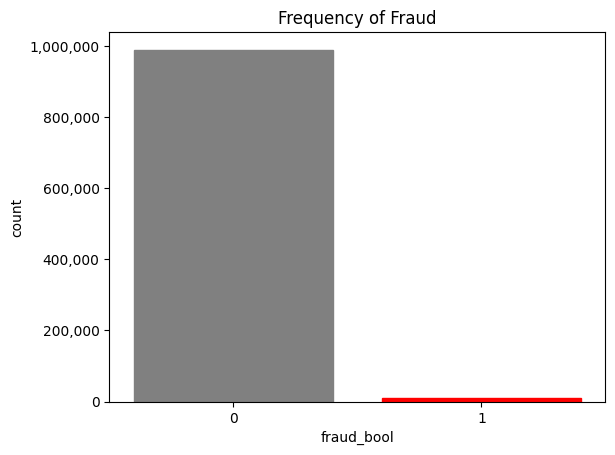

In [33]:
fig, ax = plt.subplots()
g = sns.countplot(df, x='fraud_bool', ax = ax)
ax.patches[1].set_color('red')
ax.patches[0].set_color('grey')
t = ax.set_title('Frequency of Fraud')
ytlbls = ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## MODELS ##

,recall,precision,auc,C
0,0.0,0.0,0.5,0.01
1,0.0,0.0,0.5,0.10
2,0.0,0.0,0.5,1.00
3,0.0,0.0,0.5,10.00
4,0.0,0.0,0.5,100.00


lvl 1 : test result {'recall': 0.0, 'precision': 0.0, 'auc': 0.5}


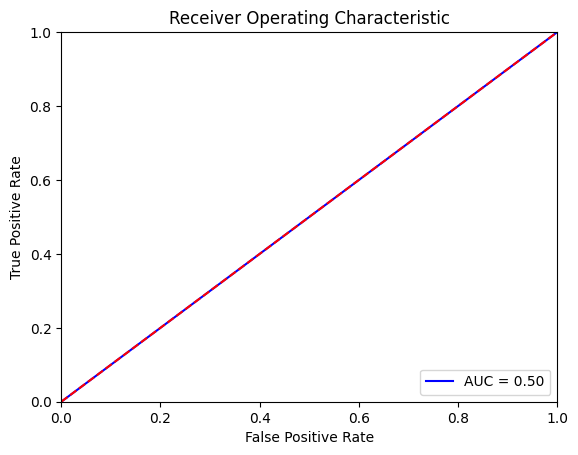

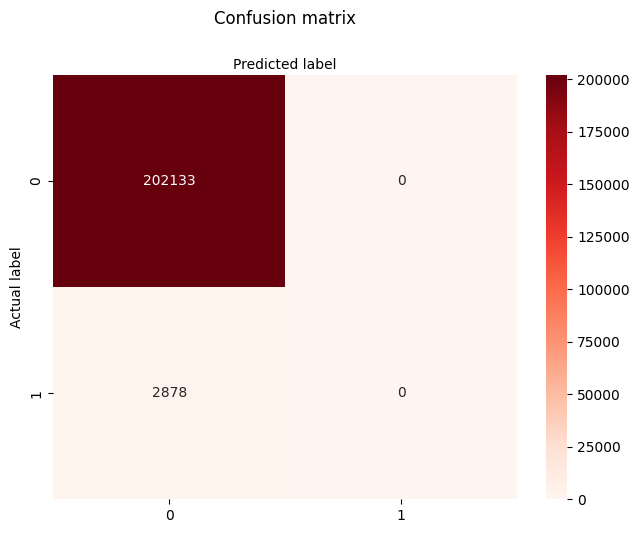

In [34]:
## Lvl 1 feature engineering, metric
lvl1_results = grid_search_cv(PARAMS, k=5, datax=processed_train_X, datay=train_y)
display(lvl1_results.head(5))
c1 = lvl1_results['C'][0]

# Train
lg1 = LogisticRegression(random_state=SEED, class_weight=None, n_jobs=3, C=c1, max_iter=10000)
lg1.fit(processed_train_X, train_y)
# Test
processed_test_X = preprocess_x(test_X, enc, scaler)
test_probs1 = lg1.predict_proba(processed_test_X)
test_y_pred1 = test_probs1[:, 1] > THRESHOLD
result1 = scoring(test_y ,test_y_pred1)
print('lvl 1 : test result', result1)
plot_roc_curve(test_y, test_y_pred1)
plot_confusion_matrix(test_y, test_y_pred1)


lvl 1.5 : test result {'recall': 0.00660180681028492, 'precision': 0.17117117117117117, 'auc': 0.5030733304704905}


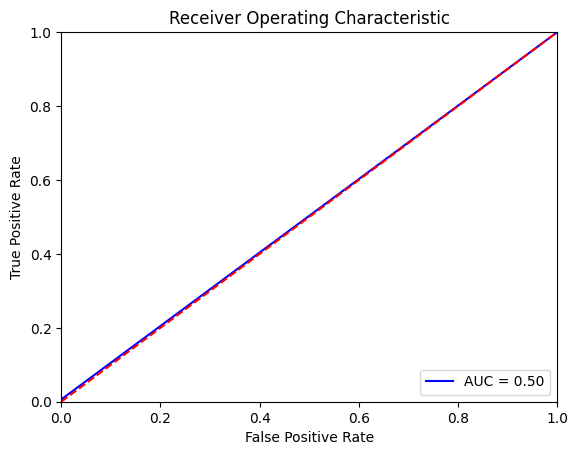

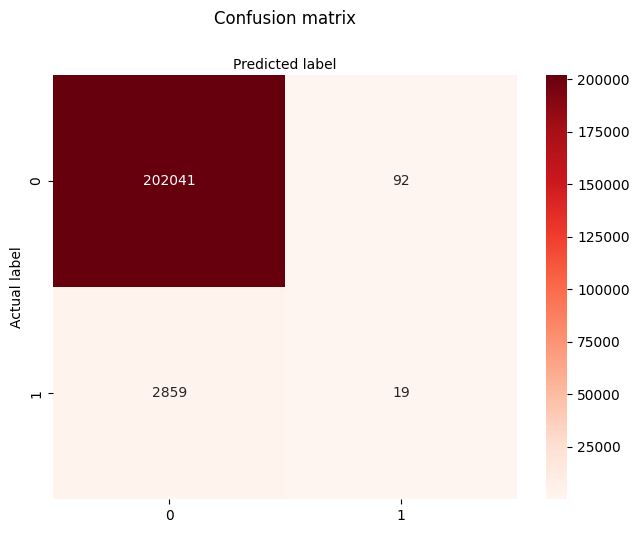

In [35]:
## Lvl 1.5 feature engineering, metric, sampling
# Train
c1 = lvl1_results['C'][0]
lg1_5 = LogisticRegression(random_state=SEED, class_weight=None, n_jobs=3, C=c1, max_iter=10000)
lg1_5.fit(X_res, y_res)

# Test
processed_test_X = preprocess_x(test_X, enc, scaler)
test_probs1_5 = lg1_5.predict_proba(processed_test_X)
test_y_pred1_5 = test_probs1_5[:, 1]> THRESHOLD
result1_5 = scoring(test_y ,test_y_pred1_5)
print('lvl 1.5 : test result', result1_5)
plot_roc_curve(test_y, test_y_pred1_5)
plot_confusion_matrix(test_y, test_y_pred1_5)

,recall,precision,auc,C
2,0.414305,0.048262,0.664832,1.00
4,0.414305,0.048262,0.664832,100.00
3,0.414182,0.048250,0.664772,10.00
1,0.414182,0.048253,0.664775,0.10
0,0.413569,0.048245,0.664523,0.01


lvl 2 : test result {'recall': 0.45830437804030577, 'precision': 0.056377158488630535, 'auc': 0.6745421055602527}


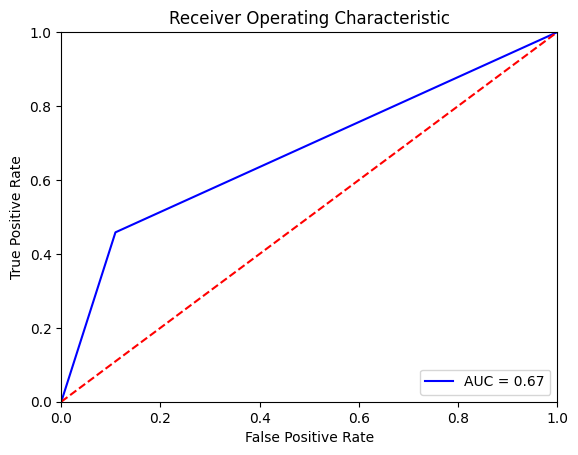

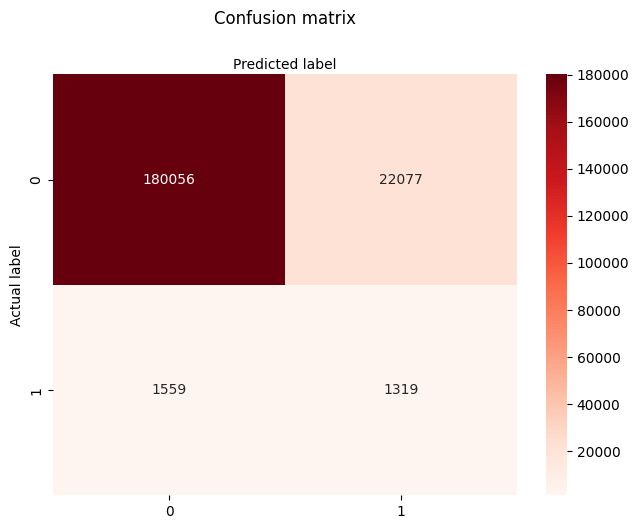

In [36]:
# level 2: feature engineering, metric, stratifed training, weights
lvl2_results = stratified_grid_search_cv(PARAMS, k=5, datax=processed_train_X, datay=train_y)
lvl2_results.head(5)
display(lvl2_results)

# Train
c2 = lvl2_results['C'][0]
lg2 = LogisticRegression(random_state=SEED, class_weight='balanced', n_jobs=3, C=c2, max_iter=10000)
lg2.fit(processed_train_X, train_y)

# Test
processed_test_X = preprocess_x(test_X, enc, scaler)
test_probs2= lg2.predict_proba(processed_test_X)
test_y_pred2 = test_probs2[:, 1] > THRESHOLD
result2 = scoring(test_y ,test_y_pred2)
print('lvl 2 : test result', result2)
plot_roc_curve(test_y, test_y_pred2)
plot_confusion_matrix(test_y, test_y_pred2)

lvl 2.5 : test result {'recall': 0.5100764419735928, 'precision': 0.05239675911054003, 'auc': 0.6893661140077282}


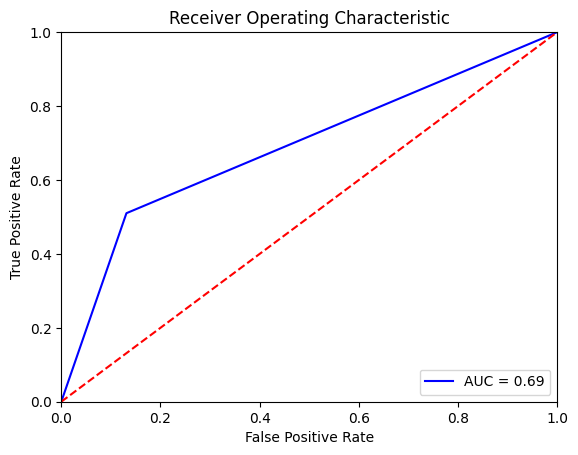

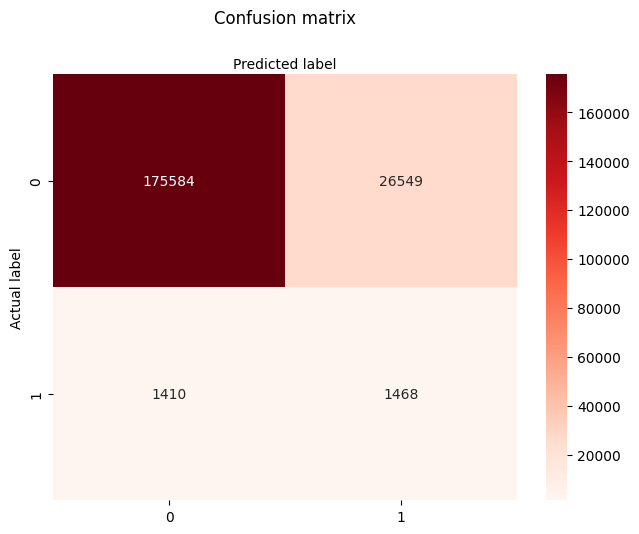

In [37]:
## LEVEL 2.5: feature engineering, metric, sampling, stratifed training, weights
# + SMOTEEN, over and under sample to 120%
# Over and under sample

# Train
c2 = lvl2_results['C'][0]
lg2_5= LogisticRegression(random_state=SEED, class_weight='balanced', n_jobs=3, C=c2, max_iter=10000)
lg2_5.fit(X_res, y_res)

# Test
processed_test_X = preprocess_x(test_X, enc, scaler)
test_probs2_5 = lg2_5.predict_proba(processed_test_X)
test_y_pred2_5 = test_probs2_5[:, 1] > THRESHOLD
result2_5 = scoring(test_y ,test_y_pred2_5)
print('lvl 2.5 : test result', result2_5)
plot_roc_curve(test_y, test_y_pred2_5)
plot_confusion_matrix(test_y, test_y_pred2_5)



## Feature importance of best model ##

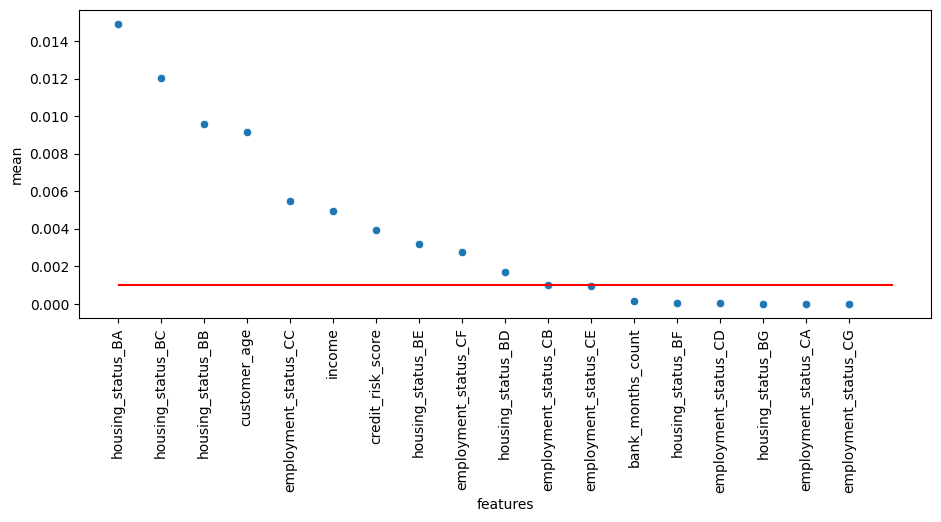

In [42]:
from sklearn.inspection import permutation_importance
r = permutation_importance(lg2_5, processed_train_X, train_y, n_repeats=30, random_state=SEED)
r_df = pd.DataFrame([processed_test_X.columns, np.abs(r.importances_mean), r.importances_std]).T
r_df.columns=['features', 'mean', 'std']
r_df = r_df.sort_values(by='mean', ascending=False)

# plot feature importance
fig, ax = plt.subplots(figsize=(11,4))
sns.scatterplot(data=r_df, x='features', y='mean', ax = ax)
ax.hlines(y=0.001, xmin=0, xmax=18, color='red')
ax.tick_params(axis='x', labelrotation=90)



## retrain model with top features ##

In [39]:
impt_features = r_df.loc[r_df['mean'] > 0.0007, 'features']
print(len(impt_features))
print(impt_features.to_list())
impt_features = ['housing_status_BA', 'bank_months_count', 'employment_status_CF', 'income', 
                 'housing_status_BE','customer_age', 'credit_risk_score',]

12
['housing_status_BA', 'housing_status_BC', 'housing_status_BB', 'customer_age', 'employment_status_CC', 'income', 'credit_risk_score', 'housing_status_BE', 'employment_status_CF', 'housing_status_BD', 'employment_status_CB', 'employment_status_CE']


lvl 3 : test result {'recall': 0.5031271716469771, 'precision': 0.05168290680658172, 'auc': 0.6858420064673221}


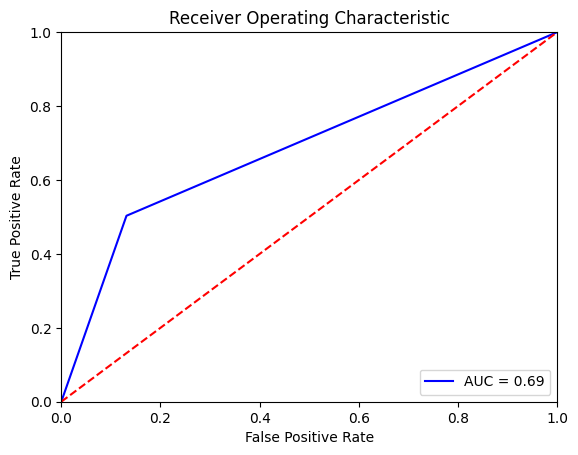

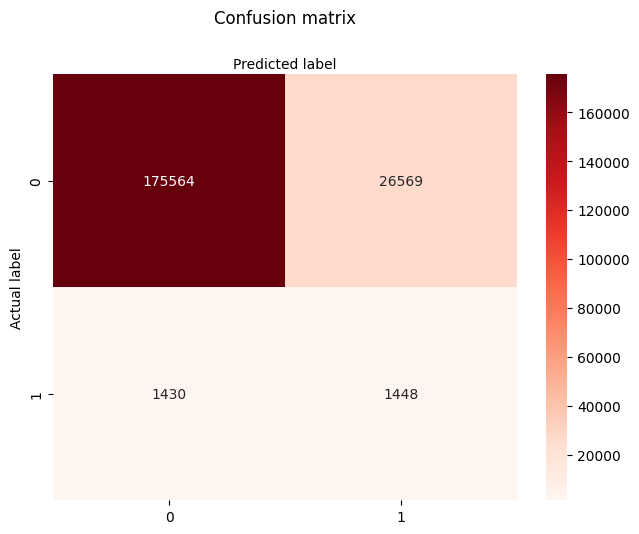

In [43]:
# lvl3 : lvl2.5 + use feature importance
# Train
c2 = lvl2_results['C'][0]
lg3= LogisticRegression(random_state=SEED, class_weight='balanced', n_jobs=3, C=c2, max_iter=10000)
lg3.fit(X_res.loc[:,impt_features], y_res)

# Test
processed_test_X = preprocess_x(test_X, enc, scaler)
test_probs3 = lg3.predict_proba(processed_test_X.loc[:,impt_features])
test_y_pred3 = test_probs3[:, 1] > THRESHOLD
result3 = scoring(test_y ,test_y_pred3)
print('lvl 3 : test result', result3)
plot_roc_curve(test_y, test_y_pred3)
plot_confusion_matrix(test_y, test_y_pred3)
